<a href="https://colab.research.google.com/github/mra49/Capstone/blob/main/SalesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [253]:
import os
os.chdir('/content/drive/MyDrive/Capstone')

In [254]:
!pip install tensorflow

###Load dataset

In [255]:
import pandas as pd
import numpy as np
#Load data
df = pd.read_csv("/content/drive/MyDrive/Capstone/df_postUnify_PreRFM.csv")

###transforming date and sorting on it

In [256]:
# Convert 'Document Date' to datetime and sort
df['Document Date'] = pd.to_datetime(df['Document Date'], errors='coerce')
df = df.sort_values(by='Document Date')

###checking for missing values

In [257]:
#Check for missing values
data_types_missing = df.dtypes.to_frame(name='Data Type').join(df.isnull().sum().rename('Missing Value Proportion'))
print(data_types_missing)


                         Data Type  Missing Value Proportion
Location                    object                     12363
Brand                       object                         0
SubBrand                    object                         0
Category                    object                      2592
SOP Number                  object                         0
Item Number                 object                         0
Item Description            object                         0
QTY                          int64                         0
Unit Price                 float64                         0
Extended Price             float64                         0
Customer Number             object                         0
Document Date       datetime64[ns]                         0
Location Code               object                         0
Item Short Name             object                         0
Customer Name               object                         0
SOP Type                

###checking for missing values in the QTY column

In [258]:
#check for any row with 0 in its quantity because it will affect our work later on
zero_qty_shampoo = df[(df['product_type'] == 'shampoo') & (df['QTY'] == 0)]

if zero_qty_shampoo.empty:
    print("There are no 0 values in 'QTY' for 'shampoo' product_type.")
else:
    print("There are 0 values in 'QTY' for 'shampoo' product_type.")

There are no 0 values in 'QTY' for 'shampoo' product_type.


###aggregating data on date (unnecessary ??)

In [259]:
# # Aggregate data by date
# daily_data = df.groupby(df['Document Date'].dt.date)['QTY'].sum().reset_index()

###extracting day month and year from date

In [260]:
#indexing daily_data now again on date
#df['Document Date'] = pd.to_datetime(df['Document Date'], errors='coerce')

# xtract the day, month, and year
df['Day'] = df['Document Date'].dt.day
df['Month'] = df['Document Date'].dt.month
df['Year'] = df['Document Date'].dt.year

# Verify the changes
print(df[['Document Date', 'Day', 'Month', 'Year']].head())


   Document Date  Day  Month  Year
0     2020-01-02    2      1  2020
61    2020-01-02    2      1  2020
60    2020-01-02    2      1  2020
59    2020-01-02    2      1  2020
58    2020-01-02    2      1  2020


###(Shampoo is the most sold)aggregating data on product type and checking most summing QTY

In [261]:
# Group by 'product_type' and sum 'QTY'
product_type_qty = df.groupby('product_type')['QTY'].sum().reset_index()

# Sort the results for better readability
product_type_qty = product_type_qty.sort_values(by='QTY', ascending=False)

# Display the result
print(product_type_qty.head(13))


          product_type     QTY
184            shampoo  646744
66         dishwashing  335826
130        laundry gel  110892
88     general cleaner   81867
118          hand soap   64482
67        disinfectant   59660
152  multi-use shampoo   49957
77      fabric softner   34251
83       floor cleaner   22988
188         shower gel   17028
4              alcohol   12441
90       glass cleaner   12069
165            oxidant    9833


In [262]:
# Calculate total sales per product (to justify choosing shampoo for forecasting)
total_sales_per_product = df.groupby('product_type')['Extended Price'].sum().reset_index()

# Calculate total sales of all products
total_sales_all_products = total_sales_per_product['Extended Price'].sum()

# Calculate proportion of each product's sales
total_sales_per_product['Sales Proportion'] = total_sales_per_product['Extended Price'] / total_sales_all_products

# Sort the results by 'Extended Price' in descending order
total_sales_per_product = total_sales_per_product.sort_values(by='Extended Price', ascending=False)

# Display the result
print(total_sales_per_product.head(15))


              product_type  Extended Price  Sales Proportion
184                shampoo    1.497706e+07          0.464375
66             dishwashing    6.338873e+06          0.196541
130            laundry gel    3.240409e+06          0.100471
88         general cleaner    1.456768e+06          0.045168
118              hand soap    1.289726e+06          0.039989
77          fabric softner    1.146069e+06          0.035535
67            disinfectant    9.795285e+05          0.030371
152      multi-use shampoo    7.068399e+05          0.021916
83           floor cleaner    6.227723e+05          0.019310
90           glass cleaner    1.625372e+05          0.005040
188             shower gel    1.306650e+05          0.004051
9    anti-dandruff shampoo    8.741831e+04          0.002710
13              antiseptic    8.474707e+04          0.002628
4                  alcohol    8.353710e+04          0.002590
17            baby shampoo    7.019463e+04          0.002176


###size cleaning to multiply with QTY

In [263]:
import pandas as pd

# Assuming df is your DataFrame

# Define a function to update product_size based on SubBrand
def update_product_size(row):
    if row['SubBrand'] == 'sh4000+s':
        return '4L'
    elif row['SubBrand'] == 'sh2250+s':  # Example condition
        return '2.25L'
    elif row['SubBrand'] == 'sh1125+s':  # Another example condition
        return '1.125L'
    # Add more conditions as needed
    else:
        return row['product_size']  # Keep the original size if none of the conditions are met

# Apply the function to update the product_size column
df['product_size'] = df.apply(update_product_size, axis=1)

In [264]:
import re
# Function to convert and standardize product size
def standardize_product_size(size):
    # Convert to string, handle None, and strip whitespace
    size_str = str(size).strip() if size is not None else ''

    # # Debug: Print the original size string
    # print("Original:", size_str)

    # Extract numeric part and unit
    numeric_part = re.sub('[^0-9.]', '', size_str)
    unit = re.sub('[0-9.]', '', size_str).lower()

    # Convert the numeric part to float
    numeric_size = float(numeric_part) if numeric_part else 0

    # Convert 'ml' or 'm' to liters
    if 'ml' in unit or 'm' in unit:
        result = f"{numeric_size / 1000}L"
    elif 'l' in unit:
        result = f"{numeric_size}L"
    elif unit == '' and numeric_size > 12:
        result = f"{numeric_size / 1000}L"
    elif unit == '':
        result = f"{numeric_size}L"
    else:
        result = f"{numeric_size}{unit}"

    # # Debug: Print the final result
    # print("Converted:", result)

    return result

# Apply the function to the 'product_size' column
df['product_size'] = df['product_size'].apply(standardize_product_size)

# Verify the changes
print(df[['Item Description', 'product_size']].head(5))


                  Item Description product_size
0   rem s1a100 my stylist straight         0nan
61   style cool ocean shampoo 2250        2.25L
60          style shanpoo 1.125l*3       1.125L
59          style shanpoo 1.125l*3       1.125L
58  style bone marrow conditioning         0nan


In [265]:
df['product_size'] = df['product_size'].replace('0.0nan', np.nan)

In [266]:
distinct_sizes = shampoo_df['product_size'].unique()

print("Distinct product sizes for 'shampoo':", distinct_sizes)

Distinct product sizes for 'shampoo': ['2.25L' '1.125L' '0.5L' '4.0L' '0nan' '6.0L' '0.08L' '0.41L' '4.1L'
 '3.0L' '0.008L' '0.9L' '0.14L' '1.0L' '1.25L' '0.037L' '0.06L']


In [267]:
print(df['product_size'].head(20))

0       0nan
61     2.25L
60    1.125L
59    1.125L
58      0nan
57      0.5L
56     0.03L
55      0.1L
54    0.015L
53     0.25L
52      0.1L
51      0.1L
50      0.1L
49      0.1L
48      0.1L
47     0.02L
46    0.055L
45      0nan
62     2.25L
63     2.25L
Name: product_size, dtype: object


In [268]:
import numpy as np

# Define your conditions and corresponding choices
conditions = [
    df['SubBrand'] == 'sh4000+s',
    df['SubBrand'] == 'sh2250+s',
    df['SubBrand'] == 'sh1125+s'
    # Add more conditions here
]

choices = [
    '4L',
    '2.25L',
    '1.125L'
    # Add corresponding choices for each condition
]

# Apply the conditions and choices
df['product_size'] = np.select(conditions, choices, default=df['product_size'])

# Display the updated DataFrame
print(df['product_size'].head(20))


0       0nan
61     2.25L
60    1.125L
59    1.125L
58      0nan
57      0.5L
56     0.03L
55      0.1L
54    0.015L
53     0.25L
52      0.1L
51      0.1L
50      0.1L
49      0.1L
48      0.1L
47     0.02L
46    0.055L
45      0nan
62     2.25L
63     2.25L
Name: product_size, dtype: object


In [269]:
import pandas as pd

# Original size_mapping
size_mapping = {
    "1.125L": ['0.0112L','1.5L', '0.112L','11.0L','10L','10.0L'],
    "2.25L": ['0.022L','0.225L','0.02L','2.0L','2.2L','2L'],
    "4.0L": ['0.4L','0.04L','4.2L','4L'],
    "5L" : ['0.055L'],
    "3L" : ['0.03L']
}

# Invert the size_mapping dictionary
inverted_size_mapping = {old_size: new_size for new_size, old_sizes in size_mapping.items() for old_size in old_sizes}

# Use map with the inverted dictionary to update the product_size column
# Retain original values where there's no mapping found
df['product_size'] = df['product_size'].map(inverted_size_mapping).fillna(df['product_size'])

# Display the updated DataFrame
print(df['product_size'].head(20))


0       0nan
61     2.25L
60    1.125L
59    1.125L
58      0nan
57      0.5L
56        3L
55      0.1L
54    0.015L
53     0.25L
52      0.1L
51      0.1L
50      0.1L
49      0.1L
48      0.1L
47     2.25L
46        5L
45      0nan
62     2.25L
63     2.25L
Name: product_size, dtype: object


In [270]:
df.to_csv("fixed_sizes.csv", index = False)

###create a new quantity column for this colab only which is the size of the product times its quantity

In [271]:
# Rename 'QTY' to 'Old QTY'
df.rename(columns={'QTY': 'Old QTY'}, inplace=True)

# Function to extract the numeric part from the 'product_size' string
def extract_size(size_str):
    if pd.isna(size_str):
        return 1  # Return 1 if size_str is NaN or None
    # Extract numbers from the string and convert to float
    return float(''.join(filter(lambda x: x.isdigit() or x == '.', size_str)))

# Apply the function to create a new column with numeric sizes
df['Numeric Size'] = df['product_size'].apply(extract_size)

# Create a new 'QTY' column by multiplying 'Old QTY' by 'Numeric Size'
df['QTY'] = df['Old QTY'] * df['Numeric Size']

# Optionally, you can drop the 'Numeric Size' column if it's no longer needed
df.drop('Numeric Size', axis=1, inplace=True)

# Display the updated DataFrame
print(df)

       Location      Brand   SubBrand            Category         SOP Number  \
0         zone1  remington  rem strtn      Persnoal Care   inv00000000005712   
61        zone1      style   sh2250+s       Personal Care  inv00000000005717   
60        zone1      style   sh1125+s       Personal Care  inv00000000005717   
59        zone1      style   sh1125+s       Personal Care  inv00000000005717   
58        zone1      style      style       Personal Care  inv00000000005716   
...         ...        ...        ...                 ...                ...   
103514    zone3      style   sh2250+s       Personal Care  inv00000000025343   
103513    zone1      foamy      foamy  Household Cleaning  inv00000000025342   
103512    zone1      foamy      foamy  Household Cleaning  inv00000000025342   
103510    zone1      foamy      foamy  Household Cleaning  inv00000000025342   
103578    zone3      foamy      foamy  Household Cleaning  inv00000000025353   

       Item Number                Item 

###create the shampoo_df (only shampoo df and check its characteristics, as of missing sizes)



In [272]:
######### TRIM df to SHAMPOO  ##########
import pandas as pd
# Filter the DataFrame for 'shampoo' product_type
shampoo_df = df[df['product_type'] == 'shampoo']
# Count the missing 'product_size' values
missing_sizes_count = shampoo_df['product_size'].isnull().sum()
# Display the count
print(f"Number of missing size values for shampoo product_type: {missing_sizes_count}")

Number of missing size values for shampoo product_type: 0


In [273]:
shampoo_df.columns

Index(['Location', 'Brand', 'SubBrand', 'Category', 'SOP Number',
       'Item Number', 'Item Description', 'Old QTY', 'Unit Price',
       'Extended Price', 'Customer Number', 'Document Date', 'Location Code',
       'Item Short Name', 'Customer Name', 'SOP Type', 'Location ID',
       'Offer Status', 'product_type', 'product_scent', 'product_size',
       'Unique Description', 'Description Length', 'Unified IN', 'Subcategory',
       'Day', 'Month', 'Year', 'QTY'],
      dtype='object')

In [274]:
# Count the number of shampoos for each size
shampoo_counts_by_size = shampoo_df['product_size'].value_counts()

print("Count of shampoos for each size:")
print(shampoo_counts_by_size)

Count of shampoos for each size:
1.125L    13367
4.0L      13363
2.25L     12986
3.0L       2800
6.0L       2343
0nan        373
0.008L       46
0.5L         32
4.1L         11
0.08L        11
1.25L         7
1.0L          5
0.9L          4
0.41L         3
0.14L         1
0.037L        1
0.06L         1
Name: product_size, dtype: int64


###Checking Outliers for recently created shampoo_df

In [275]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers #, outliers.shape[0], outliers.describe()

In [276]:
# Assuming df is your DataFrame and 'QTY' is the column you want to check
outliers_qty = detect_outliers_iqr(shampoo_df, 'QTY')

# Sort the extreme outliers by 'QTY'
outliers_qty_sorted = outliers_qty.sort_values(by='QTY')

# Display only the 'QTY' and 'Item Description' columns
print(outliers_qty_sorted[['Item Description', 'QTY']])

                           Item Description     QTY
46724  style shampoo meridian island 2250ml    72.0
43759                x-pert shampoo rose 6l    72.0
83481                x-pert shampoo rose 6l    72.0
83441                x-pert shampoo rose 6l    72.0
62125        style shampoo alpine herbs 225    72.0
...                                     ...     ...
11094                x-pert shampoo rose 6l  1800.0
9198                 x-pert shampoo rose 6l  1800.0
3989                 x-pert shampoo rose 6l  1800.0
4259                 x-pert shampoo rose 6l  1800.0
7207                 x-pert shampoo rose 6l  1800.0

[5689 rows x 2 columns]


In [277]:
# outliers_qty, count_qty, description_qty = detect_outliers_iqr(shampoo_df, 'QTY')

# # Display the count and summary of outliers
# print(f"Count of Outliers in QTY: {count_qty}")
# print("Outlier Summary for QTY:")
# print(description_qty)

checking for extreme outliers

In [278]:
def detect_extreme_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 30 * IQR

    extreme_outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return extreme_outliers

In [279]:
# Assuming df is your DataFrame and 'QTY' is the column you want to check
extreme_outliers_qty = detect_extreme_outliers_iqr(shampoo_df, 'QTY')

# Sort the extreme outliers by 'QTY'
extreme_outliers_qty_sorted = extreme_outliers_qty.sort_values(by='QTY')

# Display only the 'QTY' and 'Item Description' columns
print(extreme_outliers_qty_sorted[['Item Description', 'QTY']])

                      Item Description     QTY
103498  style shampoo  apricot & peach   800.0
28442   style apple blossom sh. 4000ml   800.0
23033    style shampoo meridian 4000ml   800.0
21517   style apple blossom sh. 4000ml   800.0
21518    style shampoo meridian 4000ml   800.0
...                                ...     ...
3989            x-pert shampoo rose 6l  1800.0
11094           x-pert shampoo rose 6l  1800.0
13681           x-pert shampoo rose 6l  1800.0
4259            x-pert shampoo rose 6l  1800.0
7207            x-pert shampoo rose 6l  1800.0

[96 rows x 2 columns]


##ARIMA

###checking for missing values in date or quantity

In [280]:
# Check for missing values in the relevant columns for ARIMA
missing_values_qty = shampoo_df['QTY'].isnull().sum()
missing_values_date = shampoo_df['Document Date'].isnull().sum()

# Display the counts of missing values
print(f"Missing Values in 'QTY': {missing_values_qty}")
print(f"Missing Values in 'Document Date': {missing_values_date}")

Missing Values in 'QTY': 0
Missing Values in 'Document Date': 0


###monthly_shampoo_df & index on M

In [281]:
import pandas as pd

# Assuming shampoo_df is your existing DataFrame and 'Document Date' is a datetime column
monthly_shampoo_df = shampoo_df.groupby(pd.Grouper(key='Document Date', freq='M'))['QTY'].sum().reset_index()

In [282]:
# Optionally, if you want the 'Document Date' column to be just the year-month format:
monthly_shampoo_df['Document Date'] = monthly_shampoo_df['Document Date'].dt.to_period('M')
# Set the 'Document Date' as the index
monthly_shampoo_df.set_index('Document Date', inplace=True)

In [283]:
monthly_shampoo_df.columns

Index(['QTY'], dtype='object')

In [284]:
# shampoo_daily = shampoo_df.groupby(shampoo_df['Document Date'].dt.date)['QTY'].sum()

In [285]:
# shampoo_daily.index = pd.to_datetime(shampoo_daily.index)
# shampoo_daily = shampoo_daily.sort_index()

###QTY vs Document Date (M) Plot for monthly_shampoo_df

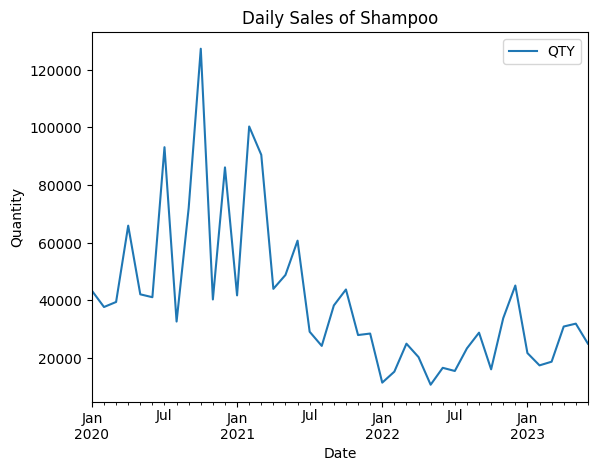

In [286]:
import matplotlib.pyplot as plt

monthly_shampoo_df.plot()
plt.title('Daily Sales of Shampoo')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()

In [287]:
# Check the number of observations in the DataFrame
n_obs = monthly_shampoo_df.shape[0]

# Print the number of observations
print("Number of observations:", n_obs)

Number of observations: 42


###plot ACF & PACF for monthly_shampoo_df

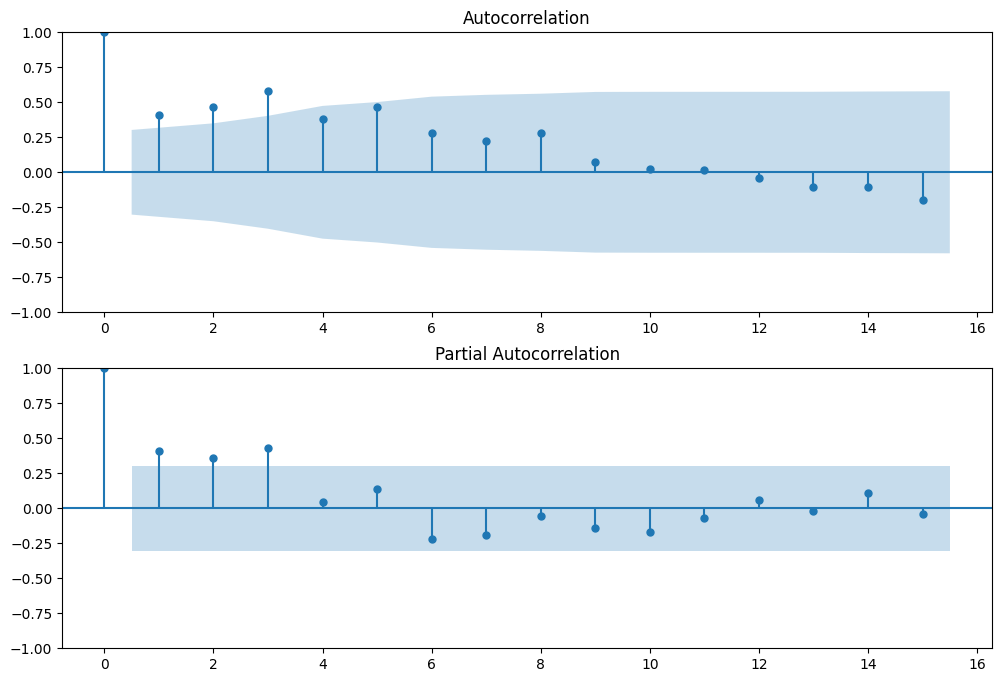

In [288]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set the number of lags for the ACF and PACF plots
n_lags = 15

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(monthly_shampoo_df['QTY'], lags=n_lags, ax=ax1)

# PACF plot
plot_pacf(monthly_shampoo_df['QTY'], lags=n_lags, method='ywm', ax=ax2)

# Display the plots
plt.show()

###AdFuller test for monthly_shampoo_df

In [289]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly_shampoo_df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.135665
p-value: 0.024024


GPT
The ADF (Augmented Dickey-Fuller) test results indicate that the time series is stationary. Here's why:

ADF Statistic: A value of -5.147788 is more negative than typical critical values for stationarity (which might range from -2.5 to -3.5 depending on the dataset size and selected confidence level). This suggests that the null hypothesis of a unit root (non-stationarity) can be rejected.

p-value: A p-value of 0.000011 is well below the common alpha level of 0.05. This indicates strong evidence against the null hypothesis, so you can conclude that the time series does not have a unit root and is stationary.

Since the time series is stationary, you can proceed with building an ARIMA model without the need for differencing (d=0). The next steps involve determining the (p) and (q) parameters of the ARIMA model, which represent the order of the autoregressive terms and the order of the moving average terms, respectively.

###Run a simple ARIMA model & diagnostics on stationary validated monthly_shampoo_df

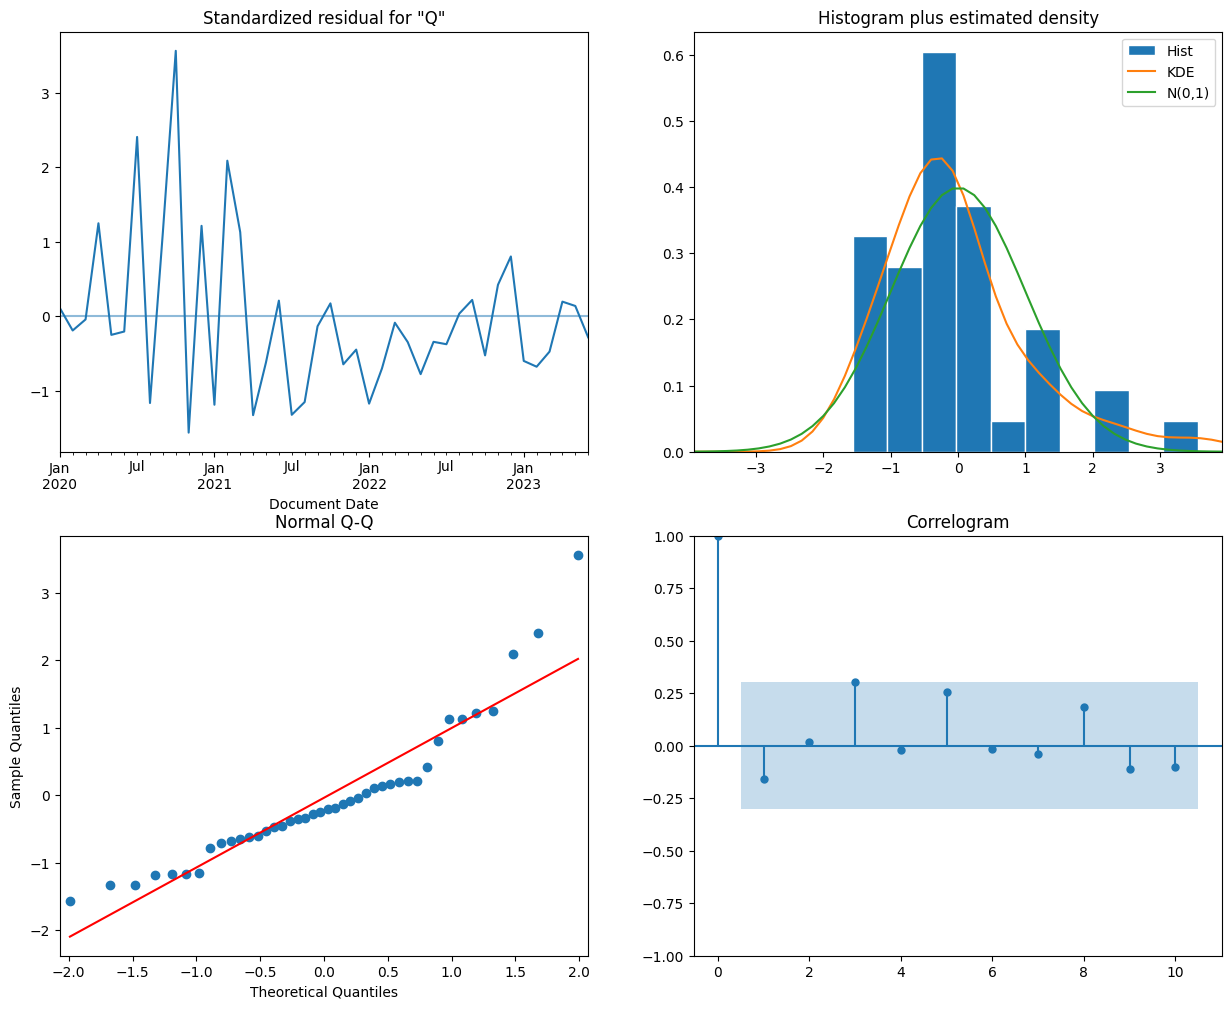

2023-07    30151.197012
2023-08    31028.832818
2023-09    31833.289456
2023-10    32570.668762
2023-11    33246.563790
Freq: M, Name: predicted_mean, dtype: float64


In [290]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit an ARIMA model (example with order (1,0,1))
model = ARIMA(monthly_shampoo_df, order=(1, 0, 1))
model_fit = model.fit()

# Model Diagnostics
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

# Make Forecast
forecast = model_fit.forecast(steps=5)  # Forecast next 5 periods
print(forecast)

###fitting the first model using proper train test split

Test RMSE: 21240.850
Mean of Test: 23863.142


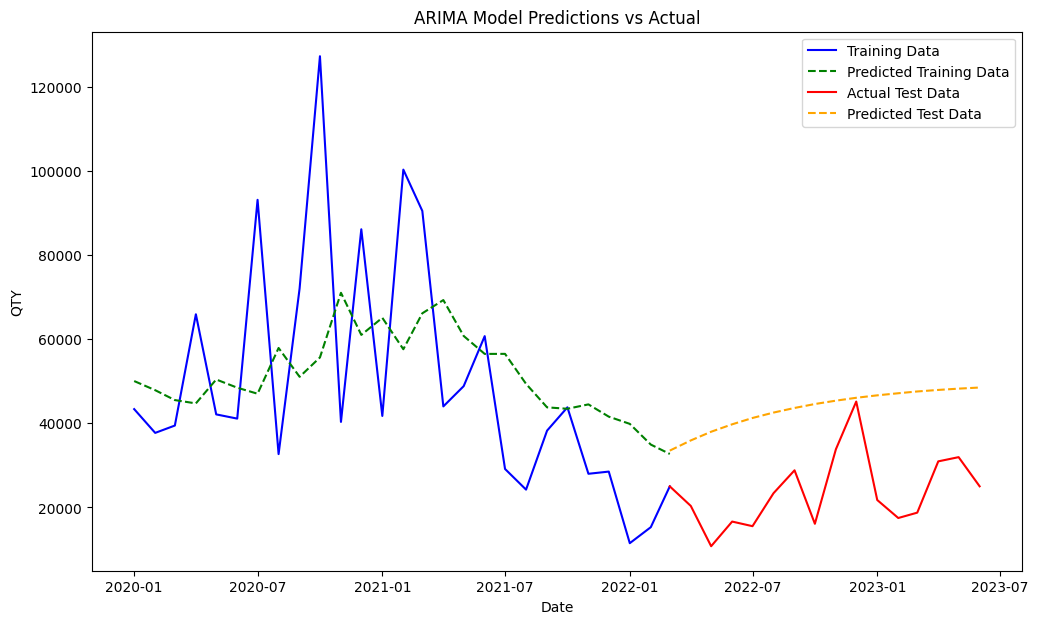

In [291]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Convert DataFrame to series
time_series = monthly_shampoo_df['QTY']

# Choose a split date
split_date = '2022-03'  # Replace 'YYYY-MM' with the actual split year and month
train = time_series[:split_date]
test = time_series[split_date:]

# Fit the ARIMA model on the training dataset
model = ARIMA(train, order=(1, 0, 1))
model_fit = model.fit()

# Make predictions on the training dataset
train_predictions = model_fit.predict(start=train.index[0], end=train.index[-1])

# Make predictions on the test dataset
test_predictions = model_fit.forecast(steps=len(test))

# Calculate RMSE for the test dataset
rmse = np.sqrt(mean_squared_error(test, test_predictions))
print('Test RMSE: %.3f' % rmse)

# Calculate the mean of the test predictions
mean_test = np.mean(test)
print('Mean of Test: %.3f' % mean_test)

# Plot the actual vs predicted values
plt.figure(figsize=(12, 7))

# Convert Period index to datetime index for plotting
train.index = train.index.to_timestamp()
test.index = test.index.to_timestamp()

# Plot training data
plt.plot(train.index, train, color='blue', label='Training Data')

# Plot training predictions
plt.plot(train.index, train_predictions, color='green', linestyle='--', label='Predicted Training Data')

# Plot testing data
plt.plot(test.index, test, color='red', label='Actual Test Data')

# Plot testing predictions
plt.plot(test.index, test_predictions, color='orange', linestyle='--', label='Predicted Test Data')

# Show the plot with labels
plt.title('ARIMA Model Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('QTY')
plt.legend()
plt.show()


###plot first diagnostics for simple arima after splitting (means of train data only)

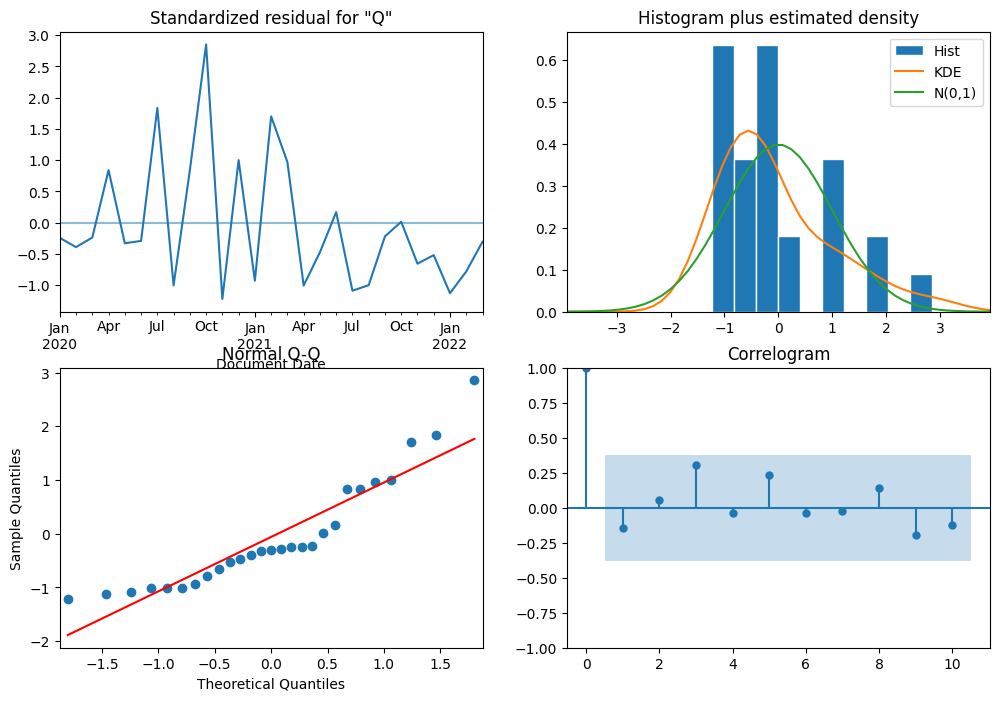

In [292]:
# Assuming you have already split the data and fit the model to the training set
model_fit = model.fit()

# Obtain the residuals
residuals = model_fit.resid

# Plot diagnostics on the training set residuals
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()


###Using box cox method to normalize residuals (homescedasticity)

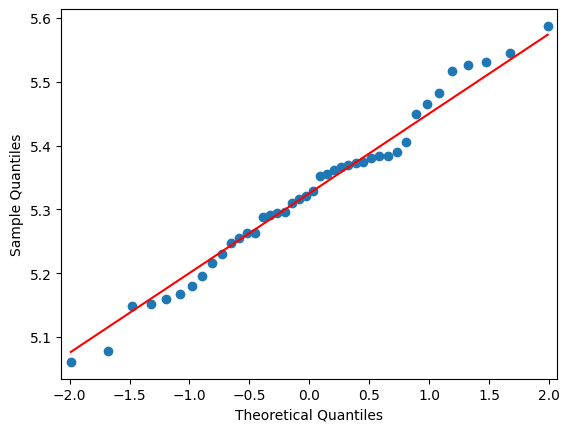

The optimal lambda value for the Box-Cox transformation is: -0.14726795076900628


In [295]:
import pandas as pd
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt

# Let's assume monthly_shampoo_df is your DataFrame and 'QTY' is the column with the data to transform
#time_series = monthly_shampoo_df['QTY']

# Check if any value is non-positive, as Box-Cox is not defined for non-positive values
if any(time_series <= 0):
    time_series += (1 - min(time_series))

# Apply Box-Cox transformation
time_series_transformed, lambda_optimal = boxcox(time_series)

# You can store the transformed time series back into the DataFrame if you want
monthly_shampoo_df['QTY_transformed'] = time_series_transformed

# Plotting Q-Q plot to check normality
qqplot(time_series_transformed, line='s')
plt.show()

# Print the optimal lambda found
print(f"The optimal lambda value for the Box-Cox transformation is: {lambda_optimal}")

# Continue with your ARIMA modeling using the transformed time series...


### use grid search to get best parameters based on AIC

In [297]:
import itertools
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings("ignore")  # Ignore warnings

# Assuming 'monthly_shampoo_df' is already defined and the 'QTY' column contains the time series data

# Define the p, d, and q ranges to search
p = range(0, 4)  # for example 0, 1, 2, 3
d = range(0, 3)  # for example 0, 1, 2
q = range(0, 4)  # for example 0, 1, 2, 3

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Test for stationarity and determine 'd' if not done already
result = adfuller(monthly_shampoo_df['QTY_transformed'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] > 0.05:
    print("Series is not stationary. Differencing will be needed.")
else:
    print("Series appears to be stationary. No differencing needed.")

# Run a grid search
best_aic = float("inf")
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(monthly_shampoo_df['QTY_transformed'], order=param)
        results = model.fit()

        # Compare this model's AIC to the best (lowest) AIC so far
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except Exception as e:
        continue

print(f"The best ARIMA model has parameters p={best_pdq[0]}, d={best_pdq[1]}, q={best_pdq[2]} with AIC={best_aic}")

# If needed, the summary of the best model can be printed
# print(best_model.summary())


ADF Statistic: -1.296253
p-value: 0.630885
Series is not stationary. Differencing will be needed.
The best ARIMA model has parameters p=1, d=0, q=3 with AIC=-73.61669679973438


Test RMSE: 15596.188
Mean of Test: 23863.142


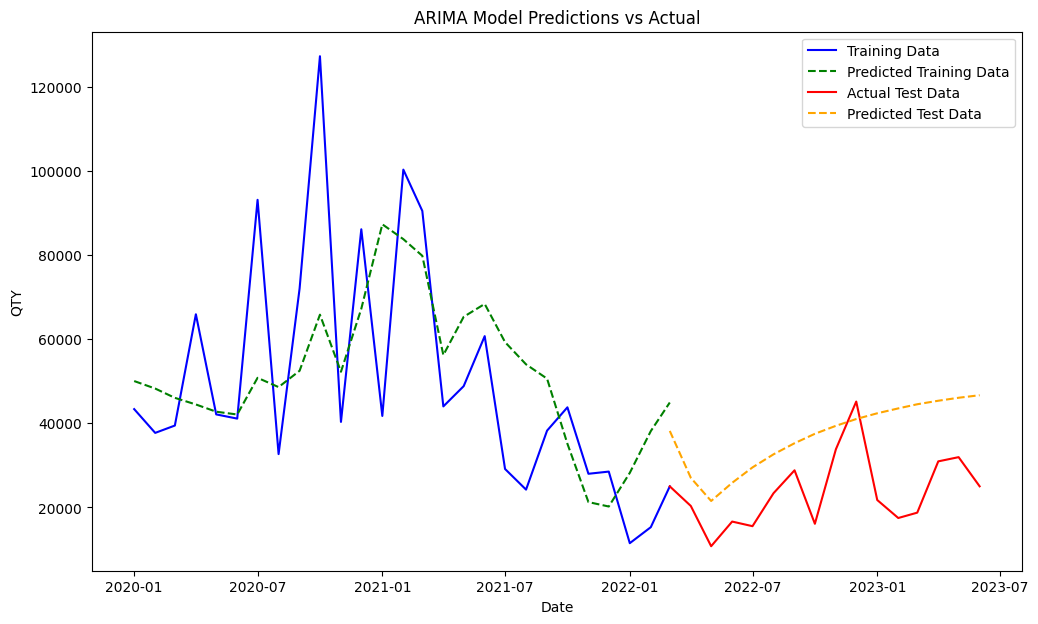

In [298]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Convert DataFrame to series
time_series = monthly_shampoo_df['QTY']

# Choose a split date
split_date = '2022-03'  # Replace 'YYYY-MM' with the actual split year and month
train = time_series[:split_date]
test = time_series[split_date:]

# Fit the ARIMA model on the training dataset
model = ARIMA(train, order=(1, 0, 3))
model_fit = model.fit()

# Make predictions on the training dataset
train_predictions = model_fit.predict(start=train.index[0], end=train.index[-1])

# Make predictions on the test dataset
test_predictions = model_fit.forecast(steps=len(test))

# Calculate RMSE for the test dataset
rmse = np.sqrt(mean_squared_error(test, test_predictions))
print('Test RMSE: %.3f' % rmse)

# Calculate the mean of the test predictions
mean_test = np.mean(test)
print('Mean of Test: %.3f' % mean_test)

# Plot the actual vs predicted values
plt.figure(figsize=(12, 7))

# Convert Period index to datetime index for plotting
train.index = train.index.to_timestamp()
test.index = test.index.to_timestamp()

# Plot training data
plt.plot(train.index, train, color='blue', label='Training Data')

# Plot training predictions
plt.plot(train.index, train_predictions, color='green', linestyle='--', label='Predicted Training Data')

# Plot testing data
plt.plot(test.index, test, color='red', label='Actual Test Data')

# Plot testing predictions
plt.plot(test.index, test_predictions, color='orange', linestyle='--', label='Predicted Test Data')

# Show the plot with labels
plt.title('ARIMA Model Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('QTY')
plt.legend()
plt.show()

##previous shiiiiittteeeee

###Plot ACF PACF for the model

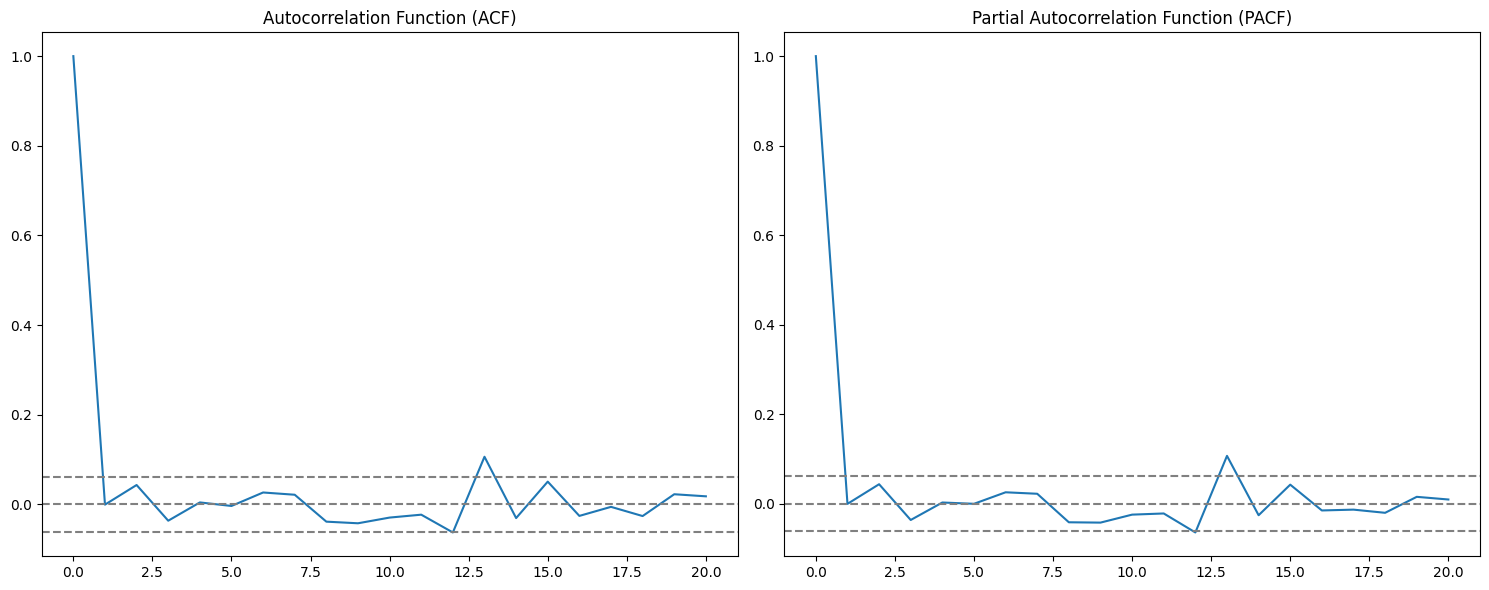

In [77]:
from statsmodels.tsa.stattools import acf, pacf

# Calculate the ACF and PACF
lag_acf = acf(model_fit.resid, nlags=20)
lag_pacf = pacf(model_fit.resid, nlags=20, method='ols')

# Plot ACF and PACF
plt.figure(figsize=(15, 6))

# ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(shampoo_daily)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(shampoo_daily)), linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF)')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(shampoo_daily)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(shampoo_daily)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In [78]:
 pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.7 MB/s eta 0:00:00


###Using auto_arima to obtain perfect parameters

In [79]:
from pmdarima import auto_arima
import pandas as pd

# Assuming shampoo_daily is your time series DataFrame for 'shampoo' product_type

# Running auto_arima to find the best ARIMA model parameters
auto_arima_model = auto_arima(shampoo_daily, start_p=0, start_q=0,
                              test='adf',       # Use adftest to find optimal 'd'
                              max_p=5, max_q=5, # Maximum p and q
                              m=1,              # Frequency of the series
                              d=None,           # Let model determine 'd'
                              seasonal=False,   # No Seasonality
                              start_P=0,
                              D=0,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

print(auto_arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18907.373, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=18601.423, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=18736.392, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=18465.116, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=18428.778, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=18395.403, Time=0.11 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=18376.029, Time=0.34 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=18311.900, Time=0.71 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=18315.055, Time=0.69 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=18314.144, Time=2.75 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=18312.521, Time=2.12 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=18328.817, Time=0.81 sec

Best model:  ARIMA(5,0,1)(0,0,0)[0]          
Total fit time: 7.871 seconds
                               SARIMAX Results                              

###fitting model and diagnostics for auto arima results

In [80]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model without the non-significant term
model = ARIMA(shampoo_daily, order=(2, 0, 2))
model_fit = model.fit()

# Display the model summary
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    QTY   No. Observations:                 1010
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -9148.949
Date:                Sat, 16 Dec 2023   AIC                          18309.899
Time:                        03:01:03   BIC                          18339.405
Sample:                             0   HQIC                         18321.108
                               - 1010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1687.4274    373.221      4.521      0.000     955.928    2418.926
ar.L1         -0.0164      0.041     -0.401      0.689      -0.097       0.064
ar.L2          0.9280      0.042     21.951      0.0

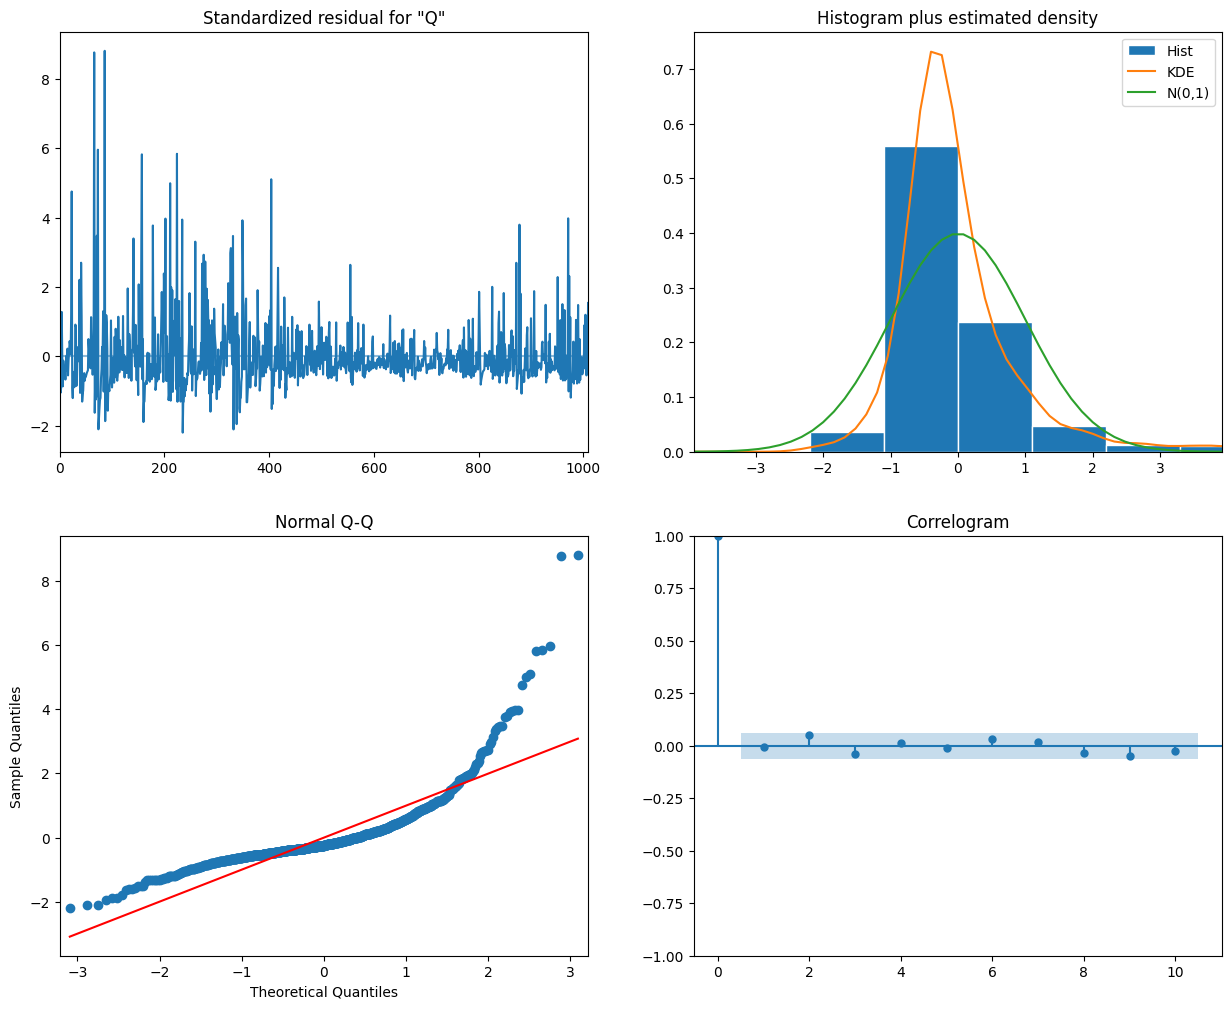

In [81]:
# Model Diagnostics
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

###fitting auto arima model by removing outliers (using the residuals)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                               SARIMAX Results                                
Dep. Variable:                    QTY   No. Observations:                 1010
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -8838.157
Date:                Sat, 16 Dec 2023   AIC                          17690.314
Time:                        03:01:05   BIC                          17724.738
Sample:                             0   HQIC                         17703.392
                               - 1010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1474.7927    231.633      6.367      0.000    1020.801    1928.784
Outlier     1.074e+04    155.942     68.859      0.000    1.04e+04     1.1e+04
ar.L1          0.0912      0.438      0.208      0.8

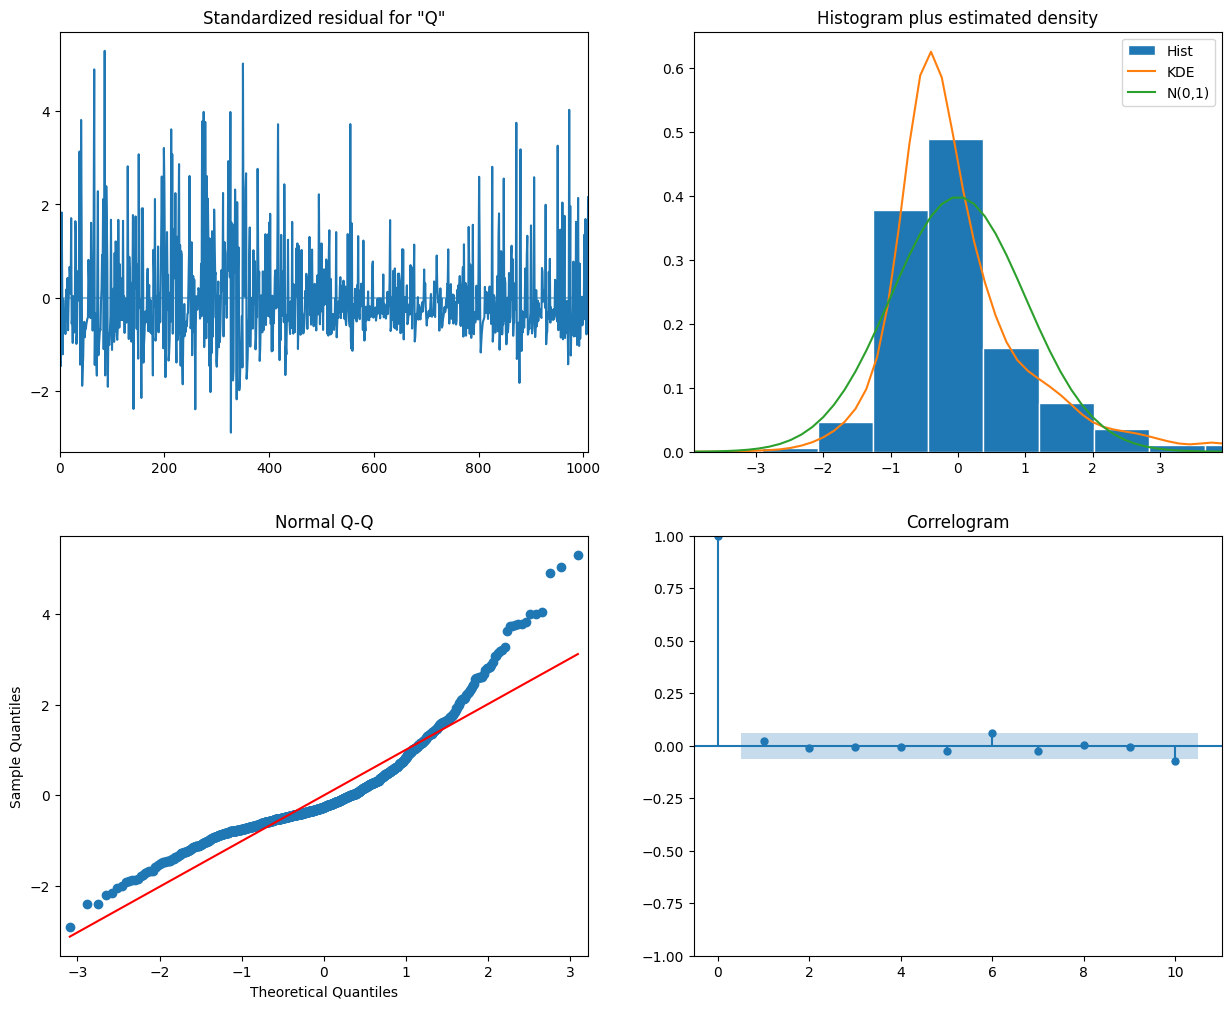

In [82]:
# Assuming 'shampoo_daily' is your Pandas Series of summed 'QTY'
shampoo_daily_df = shampoo_daily.to_frame(name='QTY')

# Ensure that 'QTY' is numeric and has no missing values
shampoo_daily_df['QTY'] = pd.to_numeric(shampoo_daily_df['QTY'], errors='coerce').fillna(0)

# Calculate the standard deviation of the residuals
residuals_std = np.std(model_fit.resid)

# Generate a boolean Series for outliers from the residuals
is_outlier = (model_fit.resid > 3 * residuals_std) | (model_fit.resid < -3 * residuals_std)

# Ensure the boolean Series for outliers is aligned with the shampoo_daily_df index
# The residuals are aligned with the model's fitted values, which correspond to the original Series' index
is_outlier_aligned = pd.Series(is_outlier, index=shampoo_daily_df.index)

# Fill NaN values with 0 for the outlier column
is_outlier_aligned_filled = is_outlier_aligned.fillna(0)

# Add the outlier information as a new column in the DataFrame
shampoo_daily_df['Outlier'] = is_outlier_aligned_filled.astype(int)

# Fit the ARIMA model with the 'Outlier' column as an exogenous variable
model_with_dummy = ARIMA(shampoo_daily_df['QTY'], exog=shampoo_daily_df[['Outlier']], order=(2, 0, 2))
model_with_dummy_fit = model_with_dummy.fit()

# Print the summary of the new model
print(model_with_dummy_fit.summary())

# Plot the diagnostics for the new model
model_with_dummy_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


###building the auto arima model using the boxcox method for outliers

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


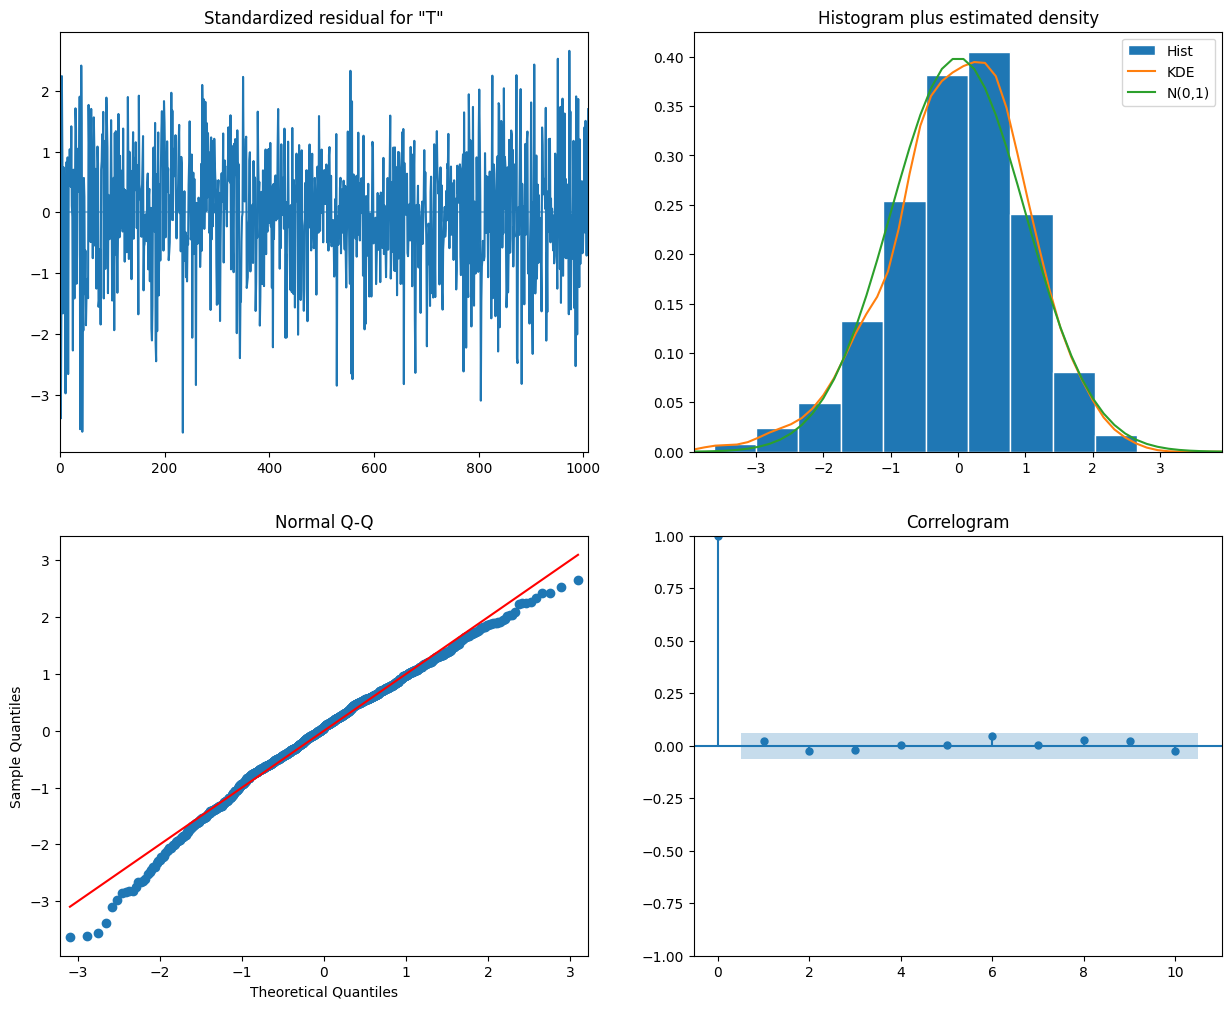

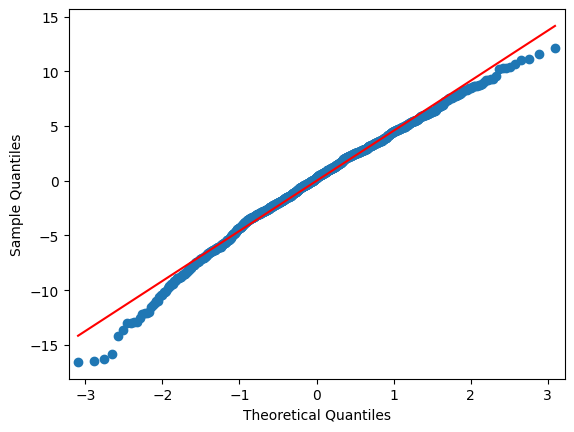

In [83]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
import pandas as pd

# Ensure all values are positive for Box-Cox Transformation
constant_to_add = abs(min(shampoo_daily_df['QTY'])) + 1
shampoo_daily_positive = shampoo_daily_df['QTY'] + constant_to_add

# Apply Box-Cox Transformation to the positive values
shampoo_daily_transformed, lambda_value = boxcox(shampoo_daily_positive)

# Create a new DataFrame for modeling which aligns the transformed data with the exogenous variable
modeling_df = pd.DataFrame({
    'Transformed_QTY': shampoo_daily_transformed,
    'Outlier': shampoo_daily_df['Outlier']
})

# Fit the ARIMA model on the transformed data
model_with_dummy_transformed = ARIMA(modeling_df['Transformed_QTY'], exog=modeling_df['Outlier'], order=(2, 0, 2))
model_with_dummy_fit_transformed = model_with_dummy_transformed.fit()

# Plot the diagnostics for the new model
model_with_dummy_fit_transformed.plot_diagnostics(figsize=(15, 12))
plt.show()

# Use qqplot to check normality visually
qqplot(model_with_dummy_fit_transformed.resid, line='s')
plt.show()


###Evaluating the model

In [84]:
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error
import numpy as np

split_date = pd.to_datetime('2022-01-01')


train_data_transformed = modeling_df[modeling_df.index <= split_date]
test_data_transformed = modeling_df[modeling_df.index > split_date]

# Fit the ARIMA model on the transformed train data
train_model_transformed = ARIMA(train_data_transformed['Transformed_QTY'], exog=train_data_transformed['Outlier'], order=(2, 0, 2))
train_model_fit_transformed = train_model_transformed.fit()

# Forecast on the transformed test data
forecast_transformed = train_model_fit_transformed.forecast(steps=len(test_data_transformed), exog=test_data_transformed['Outlier'])

# Inverse Box-Cox Transformation on forecast and actual test data
forecast_original_scale = inv_boxcox(forecast_transformed, lambda_value)
actual_original_scale = inv_boxcox(test_data_transformed['Transformed_QTY'], lambda_value)

# Calculate RMSE
mse = mean_squared_error(actual_original_scale, forecast_original_scale)
rmse = np.sqrt(mse)
print(f'Test RMSE: {rmse:.3f}')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

Test RMSE: 1136.377


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [85]:
# Calculate the mean of the original sales data
mean_original_data = shampoo_daily_df['QTY'].mean()
print(f'Mean of Original Sales Data: {mean_original_data:.3f}')

Mean of Original Sales Data: 1687.427


###Trying for Covid

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    QTY   No. Observations:                  717
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -6257.193
Date:                Sat, 16 Dec 2023   AIC                          12526.386
Time:                        03:01:11   BIC                          12553.837
Sample:                             0   HQIC                         12536.986
                                - 717                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1355.7961    346.469      3.913      0.000     676.728    2034.864
ar.L1          0.2003      0.262      0.764      0.445      -0.314       0.714
ar.L2          0.7246      0.252      2.881      0.0

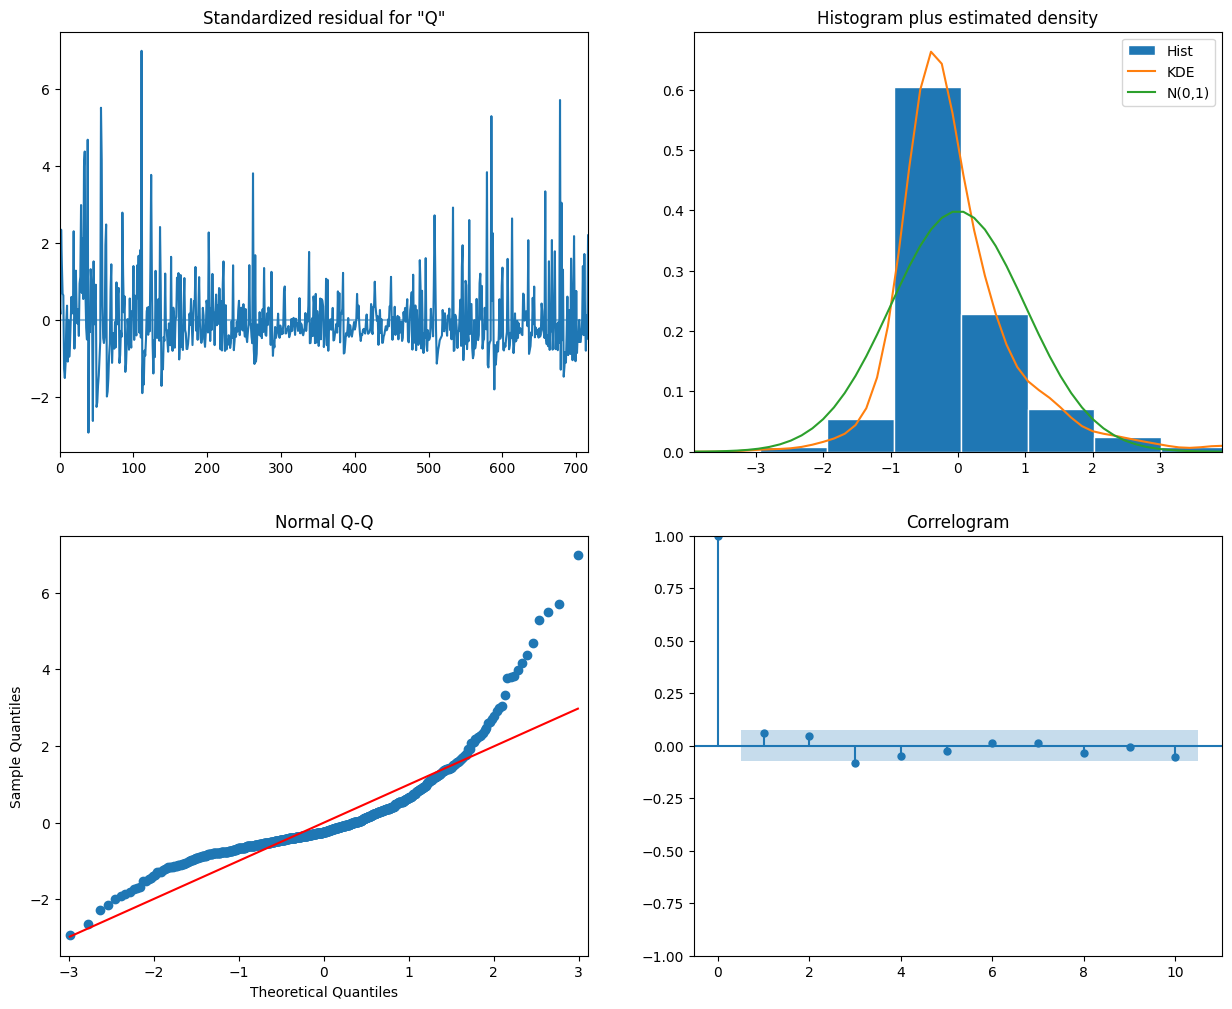

In [86]:
# Convert the index to datetime if it's not already
shampoo_daily_df.index = pd.to_datetime(shampoo_daily_df.index)

# Define the end date for the COVID period
covid_end = pd.to_datetime('2021-01-07')

# Filter the DataFrame to only include data after the COVID period
shampoo_daily_post_covid = shampoo_daily_df[shampoo_daily_df.index > covid_end]

# Since we are only using data after the COVID period, we don't need a Covid_Period dummy variable
# Now fit the ARIMA model on this filtered data
model_post_covid = ARIMA(shampoo_daily_post_covid['QTY'], order=(2, 0, 2))
model_post_covid_fit = model_post_covid.fit()

# Print the summary of the new model
print(model_post_covid_fit.summary())

# Plot the diagnostics for the new model
model_post_covid_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    QTY   No. Observations:                  578
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -4912.281
Date:                Sat, 16 Dec 2023   AIC                           9836.562
Time:                        03:01:14   BIC                           9862.719
Sample:                             0   HQIC                          9846.761
                                - 578                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1036.0624    170.405      6.080      0.000     702.076    1370.049
ar.L1          0.3090      0.340      0.908      0.364      -0.358       0.976
ar.L2          0.6262      0.332      1.886      0.0

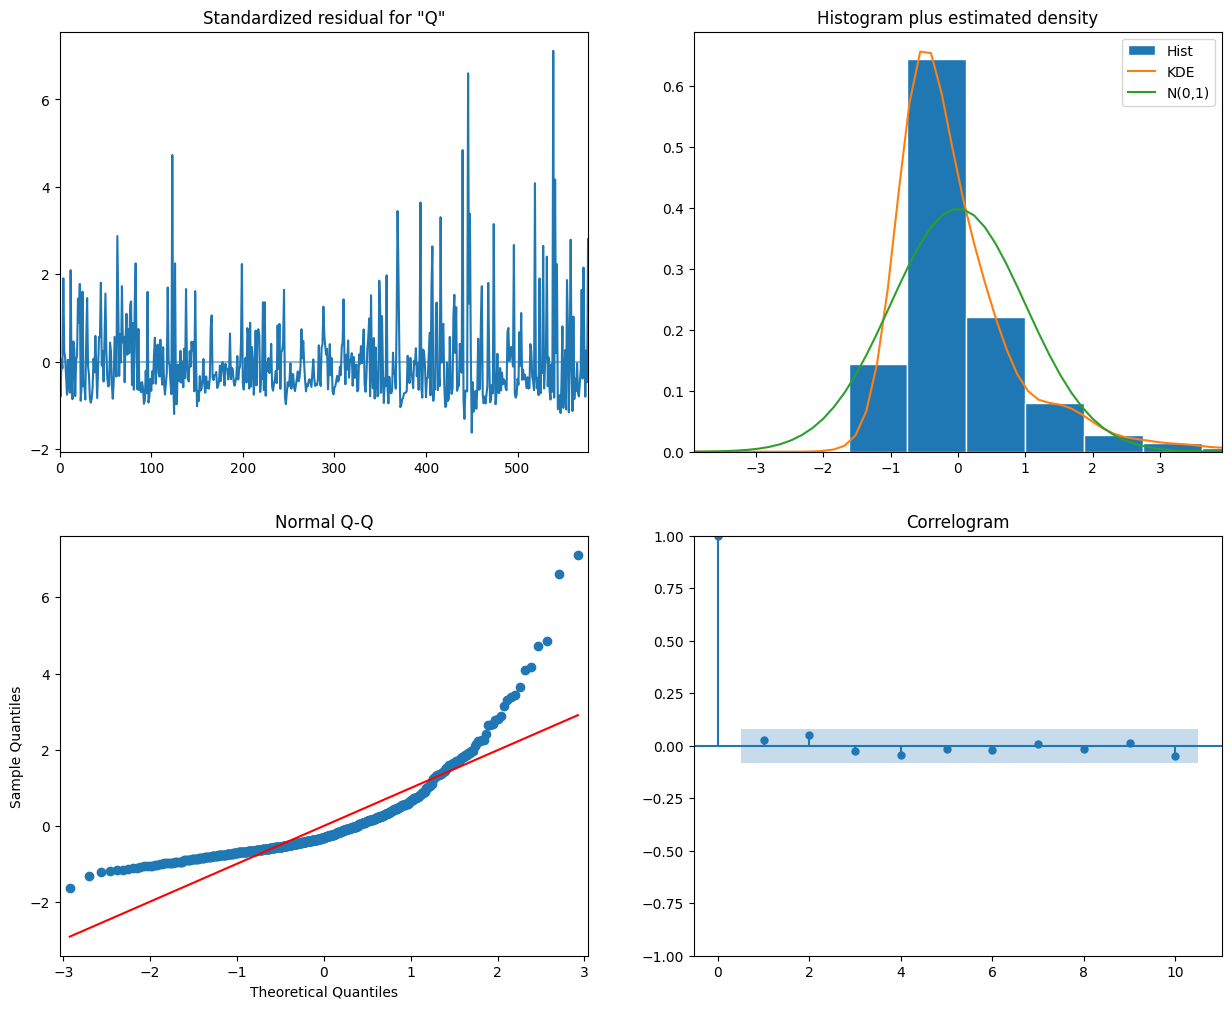

In [87]:
# Ensure the DataFrame index is of type DatetimeIndex
shampoo_daily_df.index = pd.to_datetime(shampoo_daily_df.index, errors='coerce')

# Now that we've ensured the index is datetime, filter out the COVID-19 period.
# We'll use the period after July 2021 for the ARIMA model fitting.
post_covid_data = shampoo_daily_df.loc[shampoo_daily_df.index > '2021-07-01']

# Make sure that 'QTY' is the correct column name for your sales data.
# Fit the ARIMA model using the post-COVID-19 data.
model_post_covid = ARIMA(post_covid_data['QTY'], order=(2, 0, 2))
model_post_covid_fit = model_post_covid.fit()

# Print the summary of the new model.
print(model_post_covid_fit.summary())

# Plot the diagnostics for the new model.
model_post_covid_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


In [88]:
# Assuming you've already fitted your model: model_fit
# Assuming your DataFrame is shampoo_daily_df and the date index is already converted to datetime
shampoo_daily_df.index = pd.DatetimeIndex(shampoo_daily_df.index).to_period('D')

# Split data into train and test
train_data = shampoo_daily_df[shampoo_daily_df.index <= '2022-01-01']  # Example end of training period
test_data = shampoo_daily_df[shampoo_daily_df.index > '2022-01-01']   # Example start of testing period

# Fit the model on train_data
train_model = ARIMA(train_data['QTY'], order=(2, 0, 2))
train_model_fit = train_model.fit()

# Forecast on test_data
forecast = train_model_fit.forecast(steps=len(test_data))

# Compare the forecast to the actual values
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_data['QTY'], forecast)
rmse = np.sqrt(mse)
print(f'Test RMSE: {rmse:.3f}')


Test RMSE: 1763.421


In [89]:
df.columns

Index(['Location', 'Brand', 'SubBrand', 'Category', 'SOP Number',
       'Item Number', 'Item Description', 'Old QTY', 'Unit Price',
       'Extended Price', 'Customer Number', 'Document Date', 'Item Short Name',
       'Customer Name', 'Location ID', 'Offer Status', 'product_type',
       'product_scent', 'product_size', 'Description Length', 'Subcategory',
       'With Offer', 'QTY'],
      dtype='object')

In [90]:
test_data['QTY'].mean()

953.0316159250585

In [91]:
df.to_csv("df_SF_Pre_LSTM.csv", index = False)

##LSTM Forecasting

In [371]:
#Load data
#df = pd.read_csv("/content/drive/MyDrive/Capstone/with_rate_old_prices.csv")

In [372]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error


In [373]:
# shampoo_df = df[df['product_type'] == 'shampoo']

# # Count the number of shampoos for each size
# shampoo_counts_by_size = shampoo_df['product_size'].value_counts()

# print("Count of shampoos for each size:")
# print(shampoo_counts_by_size)

In [374]:
# df.columns

In [375]:
# import pandas as pd

# # Assuming 'df' is already loaded and contains the relevant data
# # Convert 'Document Date' to datetime if it's not already
# df['Document Date'] = pd.to_datetime(df['Document Date'])

# # Filter the dataframe for 'shampoo' product_type
# shampoo_df = df[df['product_type'] == 'shampoo']

# # Sort the dataframe by 'Document Date'
# shampoo_df = shampoo_df.sort_values('Document Date')

# # Group by 'Document Date' and sum the 'QTY'
# daily_shampoo_sales = shampoo_df.groupby('Document Date')['QTY'].sum()

# # Resample the data to get a regular daily time series
# daily_shampoo_sales_resampled = daily_shampoo_sales.resample('M').asfreq().fillna(0)

# # The resulting 'daily_shampoo_sales_resampled' will have dates as the index and the summed 'QTY' as the column
# # If you want to reset the index so 'Document Date' becomes a column again, you can do so with the following line
# daily_shampoo_sales_resampled = daily_shampoo_sales_resampled.reset_index()

# # Display the first few entries of the regularized data
# print(daily_shampoo_sales_resampled.head())

# # You can then save this to a new CSV file for further use
# daily_shampoo_sales_resampled.to_csv('regularized_shampoo_sales.csv', index=False)
# daily_shampoo_df = daily_shampoo_sales_resampled

In [376]:
#daily_shampoo_df = monthly_shampoo_df

In [377]:
# # print(shampoo_daily_df.index.freq)
# print(shampoo_daily_df.index.to_series().diff().unique())

In [378]:
# Define a function to detect outliers based on IQR
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Return a boolean Series where True indicates the rows that are outliers
    return (data[column] < lower_bound) | (data[column] > upper_bound)

# Detect outliers in the 'QTY' column
outliers = detect_outliers(monthly_shampoo_df, 'QTY')

# How many outliers are there?
print("Number of outliers:", outliers.sum())


Number of outliers: 5


In [379]:
window_size = 3  # This can be tuned

# Apply a simple moving average
monthly_shampoo_df['QTY_smoothed'] = monthly_shampoo_df['QTY'].rolling(window=window_size).mean()

# Drop NaN values that result from the rolling function at the beginning of the series
monthly_shampoo_df.dropna(inplace=True)


In [380]:
split_date = pd.to_datetime('2022-01-01').to_period('M')
# Split into train and test sets
train_data = monthly_shampoo_df[monthly_shampoo_df.index < split_date]
test_data = monthly_shampoo_df[monthly_shampoo_df.index >= split_date]


In [381]:
scaler = RobustScaler()#feature_range=(0, 1)
train_scaled = scaler.fit_transform(train_data[['QTY_smoothed']])
test_scaled = scaler.transform(test_data[['QTY_smoothed']])


In [382]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1  # You can adjust this based on how many previous steps you want to consider
X_train, Y_train = create_dataset(train_scaled, look_back)
X_test, Y_test = create_dataset(test_scaled, look_back)


In [383]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [384]:
from tensorflow.keras.layers import GRU

model = Sequential()
model.add(GRU(50, input_shape=(look_back, 1), return_sequences=True))
model.add(GRU(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [385]:
model.fit(X_train, Y_train, epochs=100, batch_size=10, verbose=2)

Epoch 1/100
2/2 - 3s - loss: 0.2296 - 3s/epoch - 2s/step
Epoch 2/100
2/2 - 0s - loss: 0.2208 - 9ms/epoch - 4ms/step
Epoch 3/100
2/2 - 0s - loss: 0.2103 - 7ms/epoch - 4ms/step
Epoch 4/100
2/2 - 0s - loss: 0.2024 - 8ms/epoch - 4ms/step
Epoch 5/100
2/2 - 0s - loss: 0.1938 - 7ms/epoch - 4ms/step
Epoch 6/100
2/2 - 0s - loss: 0.1855 - 8ms/epoch - 4ms/step
Epoch 7/100
2/2 - 0s - loss: 0.1777 - 8ms/epoch - 4ms/step
Epoch 8/100
2/2 - 0s - loss: 0.1695 - 8ms/epoch - 4ms/step
Epoch 9/100
2/2 - 0s - loss: 0.1618 - 8ms/epoch - 4ms/step
Epoch 10/100
2/2 - 0s - loss: 0.1543 - 12ms/epoch - 6ms/step
Epoch 11/100
2/2 - 0s - loss: 0.1453 - 11ms/epoch - 6ms/step
Epoch 12/100
2/2 - 0s - loss: 0.1383 - 9ms/epoch - 5ms/step
Epoch 13/100
2/2 - 0s - loss: 0.1309 - 8ms/epoch - 4ms/step
Epoch 14/100
2/2 - 0s - loss: 0.1233 - 8ms/epoch - 4ms/step
Epoch 15/100
2/2 - 0s - loss: 0.1163 - 10ms/epoch - 5ms/step
Epoch 16/100
2/2 - 0s - loss: 0.1103 - 8ms/epoch - 4ms/step
Epoch 17/100
2/2 - 0s - loss: 0.1033 - 8ms/epoch

In [386]:
# optimal_model.fit(X_train, Y_train, epochs=100, batch_size=10, verbose=2)

In [387]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1/1 [==============================] - 0s 16ms/step


In [388]:
train_predict = scaler.inverse_transform(train_predict)
Y_train_inv = scaler.inverse_transform(Y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))


In [389]:
lstm_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_predict))
print(f'LSTM Test RMSE: {lstm_rmse:.3f}')


LSTM Test RMSE: 4871.140


In [390]:
# # Calculate the mean of the original sales data
# mean_original_data = daily_shampoo_df['QTY'].mean()
# print(f'Mean of Original Sales Data: {mean_original_data:.3f}')

In [391]:
# Assuming you have a variable `test_data` which contains the test portion of your dataset
mean_test_data = test_data['QTY'].mean()
print(f'Mean of Test Sales Data: {mean_test_data:.3f}')


Mean of Test Sales Data: 22702.522


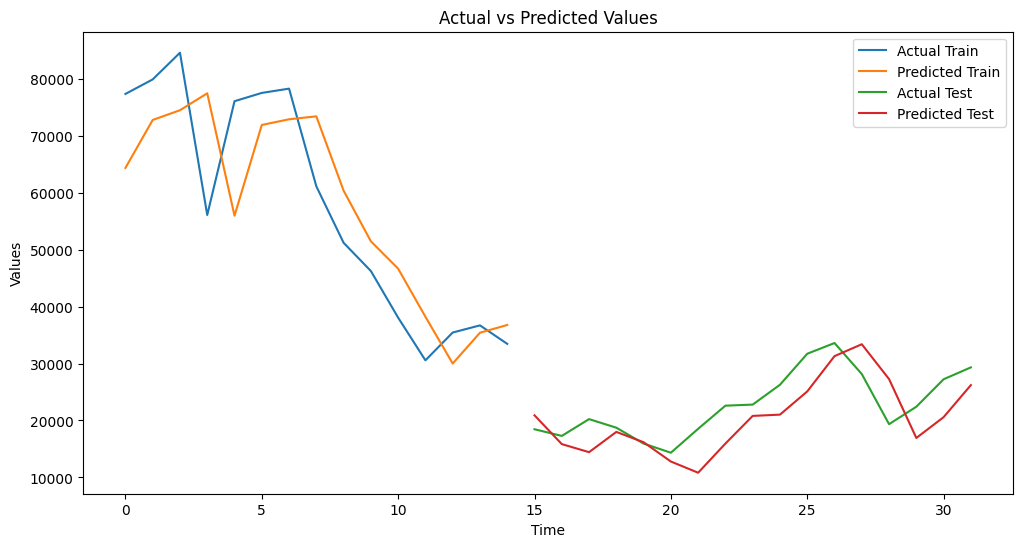

In [392]:
import matplotlib.pyplot as plt

# Assuming you have already calculated train_predict and test_predict
# And have the corresponding actual values Y_train_inv and Y_test_inv

# Plotting
plt.figure(figsize=(12, 6))

# Plotting training data
plt.plot(Y_train_inv, label='Actual Train')
plt.plot(train_predict, label='Predicted Train')

# Plotting test data
test_indices = range(len(Y_train_inv), len(Y_train_inv) + len(Y_test_inv))
plt.plot(test_indices, Y_test_inv, label='Actual Test')
plt.plot(test_indices, test_predict, label='Predicted Test')

plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()


##FB Profit

In [393]:
!pip install prophet

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spi

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph38sf_0_/qrgp3ckb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph38sf_0_/9xz93zj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64456', 'data', 'file=/tmp/tmph38sf_0_/qrgp3ckb.json', 'init=/tmp/tmph38sf_0_/9xz93zj2.json', 'output', 'file=/tmp/tmph38sf_0_/prophet_modelq0yowx6y/prophet_model-20231216062934.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:29:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:29:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


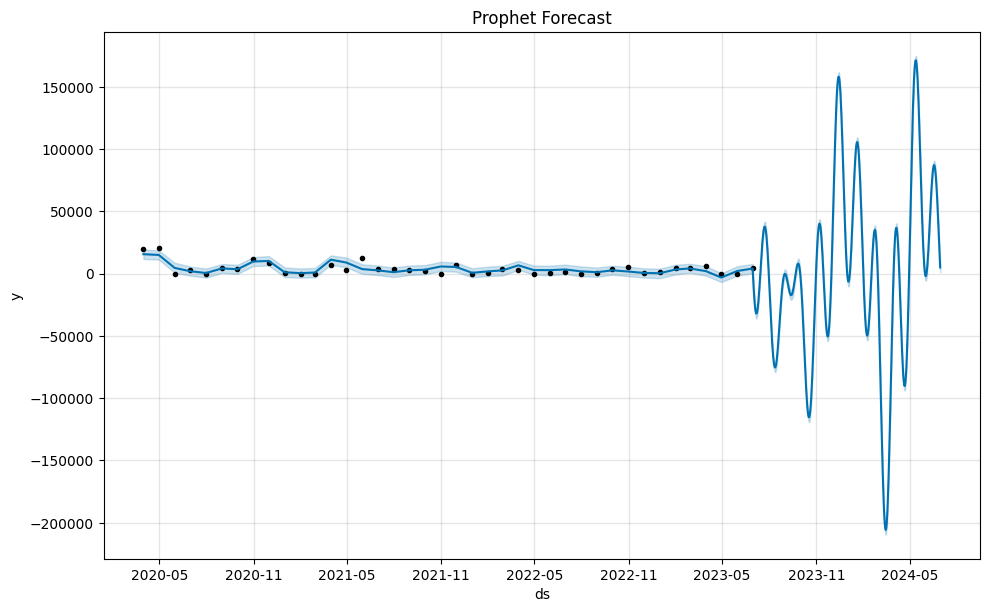

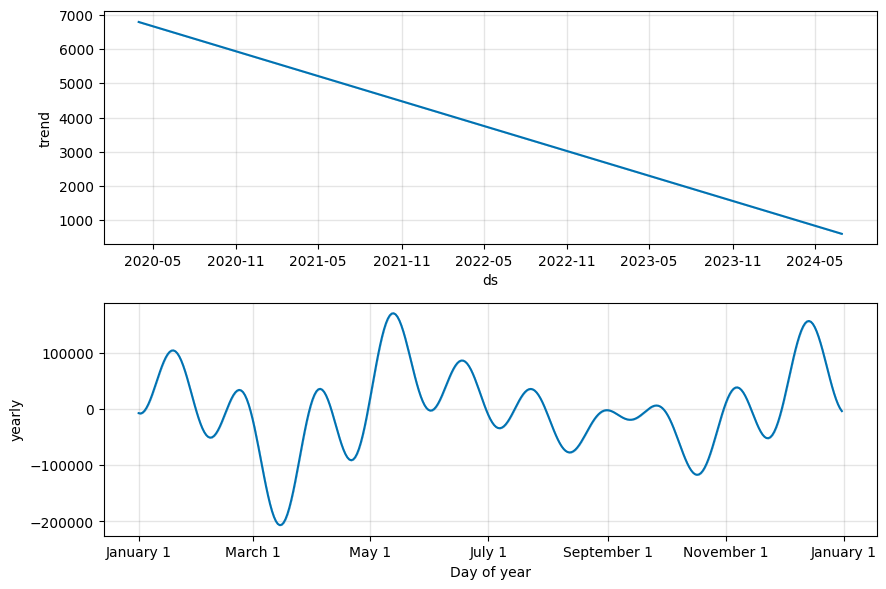

In [394]:
from prophet import Prophet

# Prepare dataset for Prophet
prophet_df = daily_shampoo_df.reset_index()
prophet_df.rename(columns={'Document Date': 'ds', 'QTY': 'y'}, inplace=True)

# Assuming daily_shampoo_df has two columns: 'Document Date' and 'QTY'

#################################

# Initialize and fit the model
m = Prophet()
m.fit(prophet_df)

##################################

# Create a dataframe for future predictions
future = m.make_future_dataframe(periods=365)  # For example, predict for the next 365 days

# Predict
forecast = m.predict(future)

# Plot the forecast
fig = m.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

##################################
# Plot the forecast components
fig2 = m.plot_components(forecast)
